In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
import tensorflow as tf
from neural_network import *
from ensembling_methods import *

# 2D Synthetic Examples

In this notebook, we'll replicate our results on the 2D examples we discuss at the beginning of the paper (and compare our method to random restarts and [negative correlation learning](https://www.sciencedirect.com/science/article/abs/pii/S0893608099000738), a common diverse ensemble benchmark that encourages models to make different training set predictions). Although these examples are simple, we think they are an important "unit test" for diverse ensemble training methods; arguably any method that tries to train an ensemble of models that make the same predictions for qualitatively different reasons should ideally output models with different decision boundaries on these datasets.

### The main takeaway we expect you to get from this notebook...

...is that encouraging models to make different _predictions_ on training examples (i.e. what NCL and other baselines do) doesn't necessarily lead to diversity in terms of decision boundaries, especially when extrapolating.

### See also...

[...the corresponding version of this notebook for our previous workshop paper](https://github.com/dtak/local-independence-public/blob/master/2D-Illustrative-Examples.ipynb), which uses similar examples but has a different focus.

## Define training sets with gaps in the data distribution

We construct these examples to have support that looks like $\mathbb{R}^2$ locally (in a small $\epsilon$-ball around all non-boundary points), but not globally -- i.e., to have gaps in their distributions where it's unclear how a classifier should generalize.

In [2]:
# First create a dense grid of points over [-10,10]^2
X = np.array([
  [x,y] for x in np.linspace(-10,10,100)
        for y in np.linspace(-10,10,100)])
np.random.shuffle(X)

# Dataset 1: diagonally opposite quadrants.
X1 = X[np.sign(X[:,0]) != np.sign(X[:,1])]
y1 = (np.sign(X1[:,0]) == -1)

# Dataset 2: rotated quadrants
R = np.array([[np.cos(np.pi/3), -np.sin(np.pi/3)],
              [np.sin(np.pi/3), np.cos(np.pi/3)]]).T
X2 = X[np.sign(X.dot(R)[:,0]) != np.sign(X.dot(R)[:,1])]
y2 = (np.sign(X2.dot(R)[:,0]) == -1)

# Dataset 3: rotated quadrants with slack
R2 = np.array(R)
R2[0,0] -= 0.4
X3 = X[np.sign(X.dot(R2)[:,0]) != np.sign(X.dot(R2)[:,1])]
y3 = (np.sign(X3.dot(R2)[:,0]) == -1)

# Dataset 4: pinwheel
X4 = X[np.sign(X[:,0]**2 - X[:,1]**2) != np.sign(2*X[:,0]*X[:,1])]
y4 = (np.sign(X4[:,0]*X4[:,1]) == -1)

## Define plotting helpers

In [3]:
def contour(f, lines=None, linewidths=6, alpha=0.9, linestyles='solid', **kw):
  set_lims()
  grid = np.linspace(-10, 10, 150)
  xg, yg = np.meshgrid(grid, grid)
  zg = griddata(X[:,0], X[:,1], f, grid, grid, interp='linear')
  if lines is not None:
    plt.contour(xg, yg, zg, lines, linewidths=linewidths, alpha=alpha, linestyles=linestyles, **kw, vmin=-1, vmax=1)
  else:
    vlim = np.abs(f).max() * 0.95
    plt.contourf(xg, yg, zg, 300, vmin=-vlim, vmax=vlim, **kw)
      
def scat(x,y,per=2, **kw):
  set_lims()
  y1 = np.argwhere(y > 0)[:,0]; np.random.shuffle(y1)
  y2 = np.argwhere(y <= 0)[:, 0]; np.random.shuffle(y2)
  plt.scatter(*x[y1][::per].T, marker='.', c='red', edgecolor=(0,0,0,0.25), s=100, **kw)
  plt.scatter(*x[y2][::per].T, marker='.', c='blue', edgecolor=(0,0,0,0.25), s=100, **kw)
  
def set_lims():
  plt.xticks([]); plt.yticks([])
  plt.xlim(-10, 10); plt.ylim(-10, 10)

## Visualize datasets

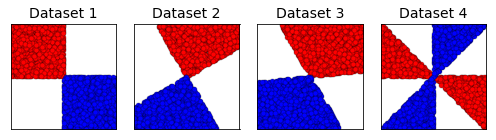

In [4]:
fig = plt.figure(figsize=(7,2));i=1
plt.subplot(1,4,i).set(adjustable='box', aspect='equal');i+=1
plt.title('Dataset 1',fontsize=14)
scat(X1,y1)
plt.subplot(1,4,i).set(adjustable='box', aspect='equal');i+=1
plt.title('Dataset 2',fontsize=14)
scat(X2,y2)
plt.subplot(1,4,i).set(adjustable='box', aspect='equal');i+=1
plt.title('Dataset 3',fontsize=14)
scat(X3,y3)
plt.subplot(1,4,i).set(adjustable='box', aspect='equal');i+=1
plt.title('Dataset 4',fontsize=14)
scat(X4,y4)
plt.tight_layout()

As we can see, these datasets contain gaps where there are no training points, and no obvious prediction that a classifier "should" make. However, we might expect that diverse classifiers should at least make different predictions in these gaps.

Dataset 1 is meant to mimic a feature selection problem, where you could obtain two classifiers that make completely different predictions by with linear models that each monopolize one feature.

Dataset 2 is a "rotated" version of Dataset 1; linear models could still work here, but they would each need to use both features to make identical train but opposite gap predictions (just in different ways).

Dataset 3 is a "constricted" version of Dataset 2. In this example, it should still be possible to make different predictions in the empty region, but decision boundaries can no longer be orthogonal (meaning we cannot obtain 100%-training-accuracy classifiers that are fully _locally independent_ by the definition we provide in the paper), so we expect some kind of trade-off.

Dataset 4 is constructed to permit locally independent classifiers, but requires nonlinear decision boundaries---an important test for any neural network method.

## Define neural network class and basic helpers for running methods

In [5]:
# We'll use a simple 2x256x2 fully connected network
class Net(NeuralNetwork):
  @property
  def x_shape(self): return [None, 2]
  @property
  def y_shape(self): return [None, 2]
  def rebuild_model(self, X, **_):
    # We use softplus here because ReLU networks appear to be unable to get high train accuracy
    # on the 2xy vs. x^2-y^2 dataset, even trained normally (not in an ensemble)
    L0 = X
    L1 = tf.layers.dense(L0, 256, name=self.name+'/L1', activation=tf.nn.softplus)
    L2 = tf.layers.dense(L1,   2, name=self.name+'/L2', activation=None)
    return [L1, L2]

In [6]:
def get_logits(m1,m2):
  res = []
  with tf.Session() as sess:
    m1.init(sess)
    m2.init(sess)
    res.append(m1.batch_eval(sess, m1.binary_logits,X))
    res.append(m2.batch_eval(sess, m2.binary_logits,X))
  tf.reset_default_graph()
  return res

def train_lit(X_,y_,overlap_penalty):
  tf.reset_default_graph()
  return get_logits(*train_diverse_models(Net,2,X_,y_,lambda_overlap=overlap_penalty,num_epochs=200,learning_rate=0.0001))
  
def train_rrs(X_,y_):
  tf.reset_default_graph()
  return get_logits(*train_restart_models(Net,2,X_,y_,num_epochs=200))

def train_ncl(X_,y_,overlap_penalty):
  tf.reset_default_graph()
  return get_logits(*train_neg_corr_models(Net,2,X_,y_,lambda_overlap=overlap_penalty,num_epochs=200,learning_rate=0.0001))

## Define a helper for running NCL repeatedly until we find the maximum $\lambda$ that permits 90% accuracy

One of the points of this example is to show that, if you define "diversity" as differences in training set predictions (as in NCL), there is an inherent tradeoff between diversity and training set accuracy; as you set the penalty term higher, training accuracy (for at least one model) should fall lower.

At the extremes, though, this leads to somewhat uninteresting behavior. At low penalty values, NCL will ignore diversity and produce identical models. At high penalty values, NCL will ignore accuracy and produce spurious diversity by making (at least one of) the models totally inaccurate.

So, to qualitatitively understand the kind of diversity that NCL encourages, we need to tiptoe right up to the threshold and find the largest penalty value that doesn't lead to spurious diversity. We'll do this by starting with lower and upper bounds (1 and 2) that we know produce these extreme cases, and exponentially narrowing down our search space by powers of 2 until we find the most penalized set of models which are both at least 90% accurate (terminating after some reasonable number of steps):

In [7]:
def train_ncl_with_highest_accurate_penalty(X, y, steps=10, verbose=False):
  lower_bound = 1.0
  upper_bound = 2.0
  best_logits = None
  for step in range(steps):
    lmb = (lower_bound + upper_bound) / 2.0
    m1, m2 = train_neg_corr_models(Net, 2, X, y, lambda_overlap=lmb, num_epochs=100, learning_rate=0.0001)
    with tf.Session() as sess:
      m1.init(sess)
      m2.init(sess)
      log1 = m1.batch_eval(sess, m1.binary_logits, X)
      log2 = m2.batch_eval(sess, m2.binary_logits, X)
    acc1 = np.mean((log1>0)==y)
    acc2 = np.mean((log2>0)==y)
    if verbose:
      print('NCL λ={}: acc1={:.2f}, acc2={:.2f}'.format(lmb, acc1, acc2))
    if acc1 > 0.9 and acc2 > 0.9:
      best_logits = get_logits(m1, m2)
      lower_bound = lmb
    elif acc1 < 0.501 and acc2 < 0.501:
      pass # we got unlucky with training, try again
    else:
      upper_bound = lmb
  assert(best_logits is not None)
  return lmb, best_logits

Excellent. Now we can run all of these methods on all of our datasets:

In [8]:
results1 = {}
best_ncl_lambda, best_ncl_logits = train_ncl_with_highest_accurate_penalty(X1, y1, verbose=True)
results1['ncl-best'] = best_ncl_logits
results1['ncl-{}'.format(0.1)] = train_ncl(X1, y1, 0.1)
results1['restarts'] = train_rrs(X1, y1)
for lmb in [0.0001,0.1]:
  results1['lit-{}'.format(lmb)] = train_lit(X1, y1, lmb)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
NCL λ=1.5: acc1=1.00, acc2=1.00
NCL λ=1.75: acc1=1.00, acc2=1.00
NCL λ=1.875: acc1=0.98, acc2=0.99
NCL λ=1.9375: acc1=0.57, acc2=0.96
NCL λ=1.90625: acc1=0.98, acc2=0.98
NCL λ=1.921875: acc1=0.97, acc2=0.96
NCL λ=1.9296875: acc1=0.50, acc2=0.97
NCL λ=1.92578125: acc1=0.97, acc2=0.97
NCL λ=1.927734375: acc1=0.96, acc2=0.96
NCL λ=1.9287109375: acc1=0.96, acc2=0.96
Instructions for updating:
Use tf.cast instead.


In [9]:
results2 = {}
best_ncl_lambda, best_ncl_logits = train_ncl_with_highest_accurate_penalty(X2, y2, verbose=True)
results2['ncl-best'] = best_ncl_logits
results2['ncl-{}'.format(0.1)] = train_ncl(X2, y2, 0.1)
results2['restarts'] = train_rrs(X2, y2)
for lmb in [0.0001,0.1]:
  results2['lit-{}'.format(lmb)] = train_lit(X2, y2, lmb)

NCL λ=1.5: acc1=1.00, acc2=1.00
NCL λ=1.75: acc1=1.00, acc2=1.00
NCL λ=1.875: acc1=0.99, acc2=0.98
NCL λ=1.9375: acc1=0.98, acc2=0.99
NCL λ=1.96875: acc1=0.91, acc2=0.93
NCL λ=1.984375: acc1=0.50, acc2=0.94
NCL λ=1.9765625: acc1=0.90, acc2=0.50
NCL λ=1.97265625: acc1=0.95, acc2=0.94
NCL λ=1.974609375: acc1=0.50, acc2=0.74
NCL λ=1.9736328125: acc1=0.50, acc2=0.50


In [10]:
results3 = {}
best_ncl_lambda, best_ncl_logits = train_ncl_with_highest_accurate_penalty(X3, y3, verbose=True)
results3['ncl-best'] = best_ncl_logits
results3['ncl-{}'.format(0.1)] = train_ncl(X3, y3, 0.1)
results3['restarts'] = train_rrs(X3, y3)
for lmb in [0.0001,0.1]:
  results3['lit-{}'.format(lmb)] = train_lit(X3, y3, lmb)

NCL λ=1.5: acc1=1.00, acc2=1.00
NCL λ=1.75: acc1=1.00, acc2=1.00
NCL λ=1.875: acc1=0.99, acc2=0.99
NCL λ=1.9375: acc1=0.97, acc2=0.95
NCL λ=1.96875: acc1=0.92, acc2=0.95
NCL λ=1.984375: acc1=0.94, acc2=0.50
NCL λ=1.9765625: acc1=0.88, acc2=0.91
NCL λ=1.97265625: acc1=0.94, acc2=0.94
NCL λ=1.974609375: acc1=0.88, acc2=0.95
NCL λ=1.9736328125: acc1=0.94, acc2=0.95


In [11]:
results4 = {}
best_ncl_lambda, best_ncl_logits = train_ncl_with_highest_accurate_penalty(X4, y4, verbose=True)
results4['ncl-best'] = best_ncl_logits
results4['ncl-{}'.format(0.1)] = train_ncl(X4, y4, 0.1)
results4['restarts'] = train_rrs(X4, y4)
for lmb in [0.0001,0.1]:
  results4['lit-{}'.format(lmb)] = train_lit(X4, y4, lmb)

NCL λ=1.5: acc1=0.74, acc2=0.72
NCL λ=1.25: acc1=0.96, acc2=0.74
NCL λ=1.125: acc1=0.73, acc2=0.74
NCL λ=1.0625: acc1=1.00, acc2=1.00
NCL λ=1.09375: acc1=1.00, acc2=1.00
NCL λ=1.109375: acc1=0.73, acc2=0.73
NCL λ=1.1015625: acc1=1.00, acc2=1.00
NCL λ=1.10546875: acc1=1.00, acc2=0.99
NCL λ=1.107421875: acc1=0.74, acc2=0.96
NCL λ=1.1064453125: acc1=0.74, acc2=0.74


Looking at the intermediate output for NCL, we can see two regimes: one with a smooth tradeoff between accuracy and diversity, and one with a steep cliff. Things are a bit trickier on the pinwheel dataset.

We'll see below that our method (LIT) is able to avoid this tradeoff entirely, except on Dataset 3 (which we designed to challenge it):

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2.
  """


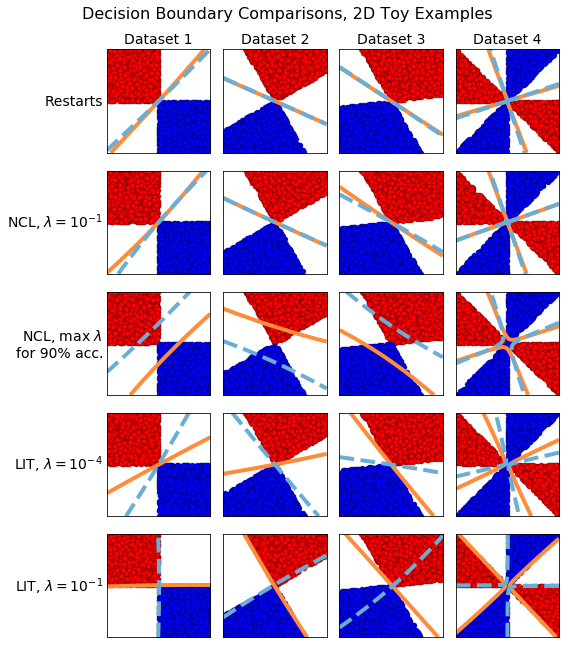

In [13]:
datasets = [(X1,y1),(X2,y2),(X3,y3),(X4,y4)]
results = [results1, results2, results3, results4]
methods = ['restarts', 'ncl-0.1', 'ncl-best', 'lit-0.0001', 'lit-0.1']
mlabels = {
  'restarts':'Restarts',
  'ncl-0.1': 'NCL, $\lambda=10^{-1}$',
  'ncl-best': 'NCL, max $\lambda$\nfor 90% acc.',
  'lit-0.0001': 'LIT, $\lambda=10^{-4}$',
  'lit-0.1': 'LIT, $\lambda=10^{-1}$'
}

cmap1 = 'Oranges'
cmap2 = 'Blues'
plot = 1
fig = plt.figure(figsize=(2*len(datasets),1.75*len(methods)))
fig.suptitle("Decision Boundary Comparisons, 2D Toy Examples",y=1.0,va='bottom', fontsize=16)
for method in methods:
  for i,r in enumerate(results):
    ax = plt.subplot(len(methods),len(datasets),plot)
    plot += 1
    X_,y_ = datasets[i]
    if method == methods[0]:
      plt.title('Dataset {}'.format(i+1), fontsize=14)
    if i == 0:
      plt.ylabel(mlabels[method], fontsize=14, rotation=0, ha='right', va='center')
    scat(X_,y_)
    r1, r2 = r[method]
    contour(r1, lines=[0], cmap=cmap1, linewidths=4, alpha=1)
    contour(r2, lines=[0], cmap=cmap2, linewidths=4, alpha=1, linestyles='dashed') 
    ax.set(adjustable='box', aspect='equal')
plt.tight_layout() 

Drilling into these results a little bit, we see:
- Random restarts produces essentially identical decision boundaries each time, despite the apparent ambiguity of the dataset
- NCL with relatively low $\lambda$ is indistinguishable from random restarts.
- NCL with high $\lambda$ can produce differences in the decision boundary, but in a way that leads to an unnecessary accuracy tradeoff, and still somewhat similar predictions throughout much of the empty space.
- Even at low $\lambda$, LIT leads to different predictions in the gap with no loss of training accuracy.
- At higher $\lambda$, LIT's decision boundaries hug the data, at the slight cost of one model's accuracy on dataset 3.

While it's not always the case that LIT's form of diversity is "better" than NCL's, what the example hopefully makes clear is that their notions of diversity are different; ensembles can have a diversity of diversities!